# How to do mesh-valued regression?

In [1]:
from pathlib import Path

import numpy as np
import pyvista as pv
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import FunctionTransformer, StandardScaler

import polpo.preprocessing.dict as ppdict
import polpo.preprocessing.pd as ppd
from polpo.models import ObjectRegressor
from polpo.plot.pyvista import RegisteredMeshesGifPlotter
from polpo.preprocessing import Map
from polpo.preprocessing.learning import DictsToXY
from polpo.preprocessing.load.pregnancy.jacobs import MeshLoader, TabularDataLoader
from polpo.preprocessing.mesh.conversion import ToVertices
from polpo.preprocessing.mesh.registration import RigidAlignment
from polpo.sklearn.adapter import AdapterPipeline
from polpo.sklearn.mesh import BiMeshesToVertices
from polpo.sklearn.np import BiFlattenButFirst, FlattenButFirst

[KeOps] Warning : cuda was detected, but driver API could not be initialized. Switching to cpu only.


In [2]:
STATIC_VIZ = True

if STATIC_VIZ:
    pv.set_jupyter_backend("static")

## Loading meshes

In [4]:
subject_id = "01"

file_finder = MeshLoader(
    subject_subset=[subject_id],
    struct_subset=["L_Hipp"],
    as_mesh=True,
)

prep_pipe = RigidAlignment(max_iterations=500)

pipe = file_finder + ppdict.ExtractUniqueKey(nested=True) + prep_pipe


meshes = pipe()

## Loading tabular data

In [5]:
subject_id = "01"

pipe = TabularDataLoader(subject_id=subject_id)

df = pipe()

INFO: Data has already been downloaded... using cached file ('/home/luisfpereira/.herbrain/data/maternal/maternal_brain_project_pilot/rawdata/28Baby_Hormones.csv').


Here, we filter the tabular data.

In [6]:
session_selector = ppd.DfIsInFilter("stage", ["post"], negate=True)

predictor_selector = (
    session_selector + ppd.ColumnsSelector("gestWeek") + ppd.SeriesToDict()
)

In [7]:
x_dict = predictor_selector(df)

## Merge data

We get the data in the proper format for fitting

In [8]:
dataset_pipe = DictsToXY()

X, meshes_ = dataset_pipe((x_dict, meshes))

X.shape, len(meshes_)

((19, 1), 19)

## Create and fit regressor

Follow [How to perform dimensionality reduction on a mesh?](./mesh_dim_reduction.ipynb), we create a pipeline to transform the output variable.

In [9]:
pca = PCA(n_components=4)

objs2y = AdapterPipeline(
    steps=[
        BiMeshesToVertices(index=0),
        FunctionTransformer(func=np.stack),
        BiFlattenButFirst(),
        StandardScaler(with_std=False),
        pca,
    ],
)

Tip: `polpo.models.Meshes2FlatVertices` is syntax sugar for the code above.

In [10]:
model = ObjectRegressor(LinearRegression(fit_intercept=True), objs2y=objs2y)

In [11]:
model.fit(X, meshes_)

,objs2y,AdapterPipeli...mponents=4))])
,steps,"[('step_0', ...), ('step_1', ...)]"
,step,<built-in function asarray>
,step,<function atl...x7e6da41cc130>
,regressor,LinearRegression()
,transformer,AdapterPipeli...mponents=4))])
,func,None
,inverse_func,None
,check_inverse,False
,fit_intercept,True
,copy_X,True


## Evaluate fit

`model.predict` outputs meshes, but we know `LinearRegression` sees `PCA` components. We can evaluate [r2_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html) by applying transform.

NB: these are values on the training data.

Tip: `objs2y` is available in `model.objs2y`.

In [12]:
meshes_pred = model.predict(X)

y_true = objs2y.transform(meshes_)
y_pred = objs2y.transform(meshes_pred)

r2_score(y_true, y_pred, multioutput="raw_values")

array([0.04356306, 0.00644142, 0.24583471, 0.00145249])

In [13]:
r2_score(y_true, y_pred, multioutput="uniform_average")

0.07432292080309397

This shows the model performs poorly. (NB: the goal of this notebook is not to find a great model, but to show how the analysis can be performed. Adapting the pipeline to use different models is a no-brainer.)

The analysis can also be done at a mesh level. The following assumes Euclidean distance.

In [14]:
meshes2flatvertices = Map(ToVertices()) + np.stack + FlattenButFirst()

r2_score(
    meshes2flatvertices(meshes_),
    meshes2flatvertices(meshes_pred),
    multioutput="uniform_average",
)

0.048441943837560994

To build understanding, let's plot the data the model actually "sees".

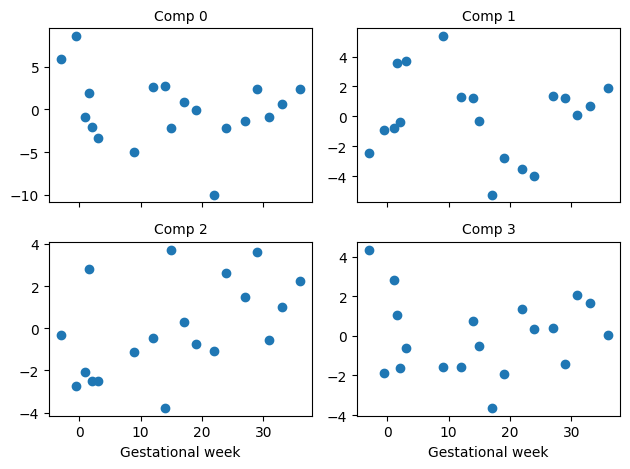

In [15]:
_, axes = plt.subplots(2, 2, sharex=True)

for index in range(4):
    ax = axes[index // 2][index % 2]
    ax.scatter(X[:, 0], y_true[:, index])
    ax.set_title(f"Comp {index}", fontsize=10)
    if index > 1:
        ax.set_xlabel("Gestational week")

plt.tight_layout()

## Visualize predictions

In [16]:
X_pred = np.linspace(-3, 42, num=10)[:, None]

meshes_pred = model.predict(X_pred)

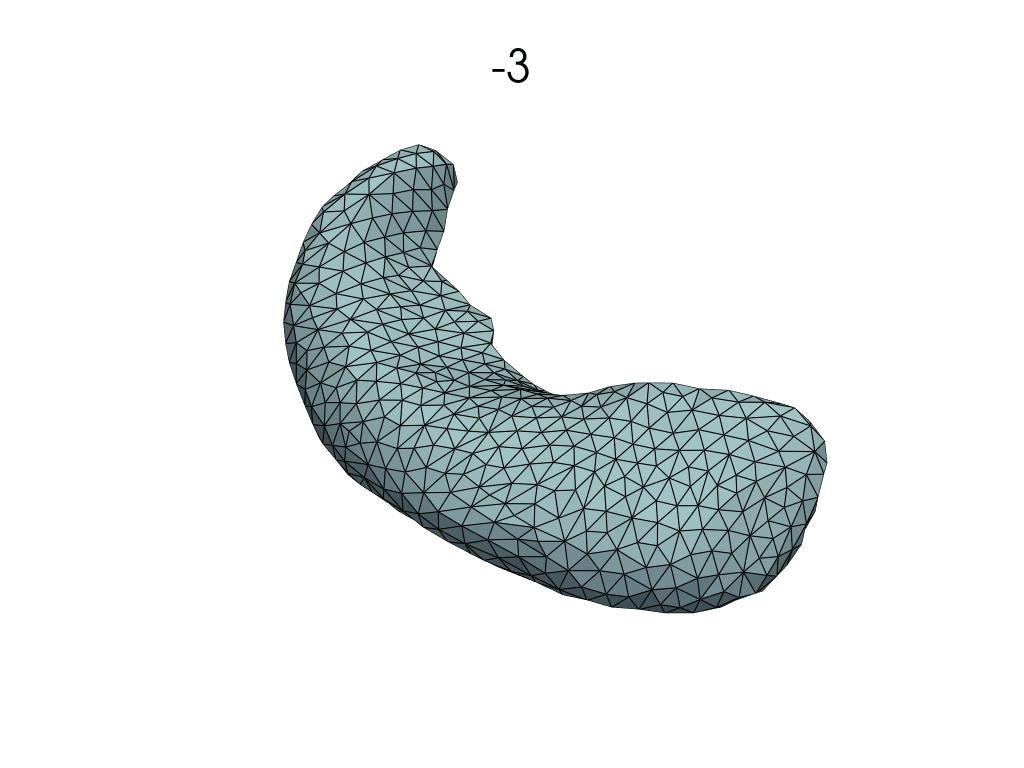

In [17]:
gif_dir = Path("_images")
gif_dir.mkdir(exist_ok=True)

gif_name = gif_dir / "regression.gif"


pl = RegisteredMeshesGifPlotter(
    gif_name=gif_name.as_posix(),
    fps=3,
)

pl.add_meshes({int(x): mesh for x, mesh in zip(X_pred[:, 0], meshes_pred)})
pl.close()

pl.show()

Let's check the predicted volumes.

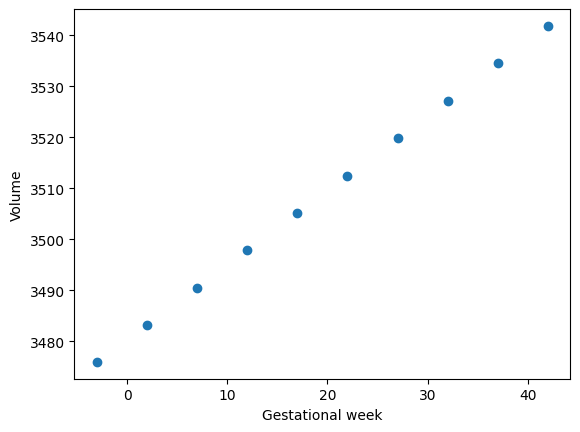

In [18]:
volumes = [mesh.volume for mesh in meshes_pred]

plt.scatter(X_pred, volumes)
plt.xlabel("Gestational week")
plt.ylabel("Volume");

## Further reading

* [How to do multiple structures mesh-valued regression?](./multimesh_valued_regression.ipynb)